# Problem 1

Let us define M = mean $\left(\sum_{ij} level_{ij}\right)$

We can define set A such that $level_{ij} - M > 0$ and set B such that $level_{ij} - M \leq 0$
k, q are the number of elements in A and B respectively.
Than we can write our objective $$ min \sum_{kq} f_{kq} c_{kq} $$
S.T.
$$ \sum_{k} c_{kq} = a_k $$ for every q.
$$ \sum_{q} c_{kq} = b_q $$ for every k.
$$ c_{kq} \geq 0 $$
$$ c_{kq} \leq d $$

In [1]:
import numpy as np
import cvxpy
    
def euclidean_distance(x0, y0, x1, y1):
    return np.sqrt((x0 - x1) ** 2 + (y0 - y1) ** 2)


heights = np.array([[5, 5, 10, 10, 10],
                    [5, 5, 10, 20, 10],
                    [0, 5, 5, 10, 5],
                    [0, 0, 0, 5, 0]],dtype = np.int)
mean = np.mean(heights, dtype = np.int)
donors = []
recipients = []

for i in range(heights.shape[0]):
    for j in range(heights.shape[1]):
        if heights[i, j] > mean:
            donors.append((heights[i, j] - mean, i, j))
        else:
            recipients.append((mean - heights[i, j], i, j))

f = np.zeros((len(donors), len(recipients)))
d = np.zeros(len(donors))
b = np.zeros(len(recipients))

for i in range(len(recipients)):
    b[i] = recipients[i][0]

for i in range(len(donors)):
    d[i] = donors[i][0]
    
    for j in range(len(recipients)):
        f[i, j] = euclidean_distance(donors[i][1], donors[i][2], recipients[j][1], recipients[j][2])

c = cvxpy.Variable(len(donors), len(recipients))

constraints = []

for i in range(len(donors)):
    constraints.append(cvxpy.sum_entries(c[i:(i + 1), :]) == d[i])
    
for i in range(len(recipients)):
    constraints.append(cvxpy.sum_entries(c[:, i:(i + 1)]) == b[i])
    
for i in range(len(donors)):
    for j in range(len(recipients)):
        constraints.append(c[i, j] >= 0)
        constraints.append(c[i, j] <= d[i])

# Form objective.
objective = cvxpy.Minimize(cvxpy.trace(c * f.T))

# Form and solve problem.
solution = cvxpy.Problem(objective, constraints)
solution.solve(solver = 'GUROBI')

print('Optimal value is: {0}'.format(solution.value))
print('c = \n{0}'.format(c.value))

Optimal value is: 95.4910638367
c = 
[[ 1.  1.  1.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  4.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  3.]
 [ 0.  0.  0.  0.  2.  1.  0.  0.  1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  1.  0.  5.  6.  2.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  3.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  4.  0.  0.]]


# Problem 2

In [5]:
import numpy as np
import numpy.matlib
import cvxpy
import copy

np.random.seed(1)

C = 20 # number of clients
clients = np.random.rand(2,C) #client positions
F = 15 # number of facilities
facilities = np.random.rand(2,F)

capacities = np.ones((F,)) * 4 #maximum number of clients per facility

dx = np.matlib.repmat(clients[0,:],F,1) - np.matlib.repmat(facilities[0,:],C,1).transpose()
dy = np.matlib.repmat(clients[1,:],F,1) - np.matlib.repmat(facilities[1,:],C,1).transpose()

assignment_costs = 3 * (dx * dx + dy * dy) #the assignment cost is the distance squared

opening_costs = np.ones((F,))

def get_lower_bound(opened = []):
    assignments = cvxpy.Variable(F, C)
    openings = cvxpy.Variable(F)

    constraints = []

    for index, is_opened in opened:
        constraints.append(openings[index] == is_opened)
        
    for i in range(F):
        constraints.append(cvxpy.sum_entries(assignments[i, :]) <= capacities[i] * openings[i])

        for j in range(C):
            constraints.append(assignments[i, j] <= 1)
            constraints.append(assignments[i, j] >= 0)

    for i in range(C):
        constraints.append(cvxpy.sum_entries(assignments[:, i]) == 1)
        constraints.append(assignments[:, i] <= openings)

    constraints.append(openings <= 1)
    constraints.append(openings >= 0)

    objective = cvxpy.Minimize(cvxpy.trace(assignments * assignment_costs.T) + opening_costs * openings)

    solution = cvxpy.Problem(objective, constraints)
    solution.solve(solver = 'GUROBI')
    
    return (solution.value, assignments.value, openings.value)

def is_integer(openings):
    for opening in openings:
        if opening != int(opening):
            return False
        
    return True

def branch_facilities(openings):
    fractionality = np.array(openings - openings.astype(np.int)).transpose()[0]
    
    if fractionality.max() == 0:
        return -1
    
    return np.where(fractionality == fractionality.max())[0][0]

def branch_and_bound():
    _, _, openings = get_lower_bound()
    L = [(openings, [])]
    best_solution = None
    incumbent_value = np.inf
    
    while L:
        openings, constraints = L.pop()

        facility = branch_facilities(openings)
        
        if facility == -1:
            continue
        
        for j in range(2):
            tmp_constraints = copy.deepcopy(constraints)
            
            try:
                lower_bound, assignments, openings = get_lower_bound(tmp_constraints + [(facility, j)])
            except cvxpy.SolverError:
                lover_bound = np.inf

            if lower_bound >= incumbent_value:
                continue

            if is_integer(openings):
                incumbent_value = lower_bound
                best_solution = (lower_bound, assignments, openings)
            else:
                tmp_constraints.append((facility, j))
                L.append((openings, tmp_constraints))
         
        
    return best_solution

best_solution = branch_and_bound()
print 'The optimal objective is {0}'.format(best_solution[0])
best_solution[1]

The optimal objective is 7.57111292313


matrix([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  1.,  1.,  0.,
          0.,  0.,  1.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  1.,  0.,  1.,  0.,  0.,  1.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,

# Problem 3

We can formulate the problem as:

$$\max \sum_{ij} c_{ij} f_{ij} $$
S.T.
for every i $$\sum_{j} c_{ij} = 1$$
for every j $$\sum_{j} c_{ij} = 1$$
$$c_{ij} = c_{ji}$$
$$c_{ij} = {0, 1}$$

Where $f_{ij}$ student i preference to live with j neighbour, that is symmetric ($f_{ij} = f_{ji}$).

Optimal value is: 16.4702055985
c = 
[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.
   0.  0.]
 [ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.
   0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.]
 [ 0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.]
 [ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.
   0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.
   0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0

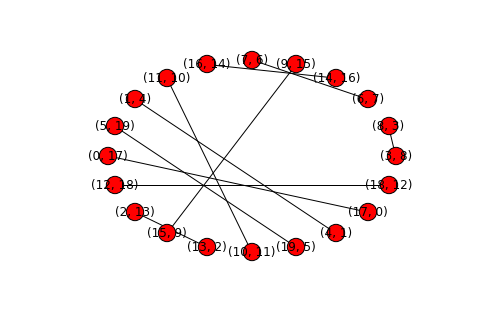

In [7]:
import numpy as np
import cvxpy
import networkx as nx
%matplotlib inline

def generate_preferences(n, seed = 26, make_bool = False):
    np.random.seed(seed)

    if make_bool:
        preferences = np.random.randint(2, size=(n, n))
    else:
        preferences = np.random.random((n, n))
 
    preferences = (preferences + preferences.T) / 2
    np.fill_diagonal(preferences, -100)
    
    return preferences


def generate_graph(matrix):
    G = nx.Graph()

    for i in range(matrix.shape[0]):
        for j in range(matrix.shape[1]):
            if matrix[i, j] > 10e-7:
                G.add_node((i, j))
                
    for node1 in G.nodes():
        for node2 in G.nodes():
            if node1 != node2 and (node1[0] == node2[0] or 
                                   node1[1] == node2[0] or
                                   node1[0] == node2[1] or
                                   node1[1] == node2[1]):
                G.add_edge(node1, node2)
                
    return G


def draw(matrix):
    nx.draw_circular(generate_graph(matrix), with_labels = True)

    
def solve(n, cuts = [], make_integer = False, make_bool = False):
    if make_integer:
        C = cvxpy.Bool(n, n)
    else:
        C = cvxpy.Variable(n, n)

    preferences = generate_preferences(n, make_bool = make_bool)

    constraints = []
    
    constraints.append(C >= 0)
    constraints.append(C <= 1)
    
    for cut in cuts:
        constraint = C[cut[0][0], cut[0][1]]

        for i in range(1, len(cut)):
            constraint += C[cut[i][0], cut[i][1]]
        
        constraints.append(constraint <= len(cuts) / 2)

    for i in range(n):
        constraints.append(cvxpy.sum_entries(C[i, :]) == 1)
        constraints.append(cvxpy.sum_entries(C[:, i]) == 1)

        for j in range(n):
            constraints.append(C[i, j] == C[j, i])

    objective = cvxpy.Maximize(cvxpy.trace(C * preferences.T))

    solution = cvxpy.Problem(objective, constraints)
    solution.solve(solver = 'GUROBI')
    
    return (solution.value, C.value)

n = 20
integer_value, integer_conf = solve(n, make_integer = True)
print('Optimal value is: {0}'.format(integer_value))
print('c = \n{0}'.format(integer_conf))
draw(integer_conf)

Optimal value is: 15.7409080881
c = 
[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.
   0.  0.]
 [ 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.
   0.  0.]
 [ 0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  1.]
 [ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.
   0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.
   0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.
   0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   1.  0.]
 [ 0.  0.  0.  1.  0.  0.  0

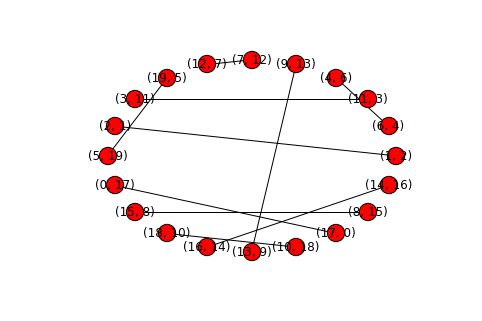

In [4]:
def solve_with_cuts(n, make_bool = False):
    cuts = []
    finished = False
    current_value = None
    current_conf = None

    while not finished:
        finished = True
        current_value, current_conf = solve(n, cuts = cuts, make_bool = make_bool)
        graph = generate_graph(current_conf)

        for cc in nx.connected_components(graph):
            if len(cc) > 2:
                cuts.append(tuple(cc))
                finished = False

    return (current_value, current_conf)

n = 20
current_value, current_conf = solve_with_cuts(n)
print('Optimal value is: {0}'.format(current_value))
print('c = \n{0}'.format(current_conf))
draw(current_conf)

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

N = [20]
integer_performance = []
cuts_performance = []

for n in N:
    t = %timeit -o solve(n)
    integer_performance.append(t.best)
    
    t = %timeit -o solve_with_cuts(n)
    cuts_performance.append(t.best)
    
# plt.xscale('log')
# plt.yscale('log')
# plt.ylabel('Execution time')
# plt.xlabel('N')
# plt.plot(N, integer_performance, label='Integer')
# plt.plot(N, cuts_performance, label='Cuts')
# plt.legend(loc='best')
# plt.show()

1 loops, best of 3: 309 ms per loop
1 loops, best of 3: 2.3 s per loop


We can see, that performance of Gurobi integer solver is much better. Moreover the objective value is more optimal than in my own cuts solution. Also we can see, that my solution cannot work with impurs of size bigger than 20.

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

N = [20]
integer_performance = []
cuts_performance = []

for n in N:
    t = %timeit -o solve(n, make_bool = True)
    integer_performance.append(t.best)
    
    t = %timeit -o solve_with_cuts(n, make_bool = True)
    cuts_performance.append(t.best)
    
# plt.xscale('log')
# plt.yscale('log')
# plt.ylabel('Execution time')
# plt.xlabel('N')
# plt.plot(N, integer_performance, label='Integer')
# plt.plot(N, cuts_performance, label='Cuts')
# plt.legend(loc='best')
# plt.show()

1 loops, best of 3: 282 ms per loop
1 loops, best of 3: 350 ms per loop


for boolean input my algorythm works for biger than n = 20 to long time too. But now results are much better.